In [127]:
import pandas as pd
import numpy as np
import xgboost as xgb
import random
#from pandas_profiling import ProfileReport

In [128]:
train_data = pd.read_csv('NSL-KDD/KDDTrain+.txt')
test_data  = pd.read_csv('NSL-KDD/KDDTest+.txt')
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'_count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

train_data.columns=columns
test_data.columns =columns

In [129]:
attack_category_map =   { 'normal': 'normal',
                        
                        'back': 'DoS',
                        'land': 'DoS',
                        'neptune': 'DoS',
                        'pod': 'DoS',
                        'smurf': 'DoS',
                        'teardrop': 'DoS',
                        'mailbomb': 'DoS',
                        'apache2': 'DoS',
                        'processtable': 'DoS',
                        'udpstorm': 'DoS',
                        
                        'ipsweep': 'Probe',
                        'nmap': 'Probe',
                        'portsweep': 'Probe',
                        'satan': 'Probe',
                        'mscan': 'Probe',
                        'saint': 'Probe',
                    
                        'ftp_write': 'R2L',
                        'guess_passwd': 'R2L',
                        'imap': 'R2L',
                        'multihop': 'R2L',
                        'phf': 'R2L',
                        'spy': 'R2L',
                        'warezclient': 'R2L',
                        'warezmaster': 'R2L',
                        'sendmail': 'R2L',
                        'named': 'R2L',
                        'snmpgetattack': 'R2L',
                        'snmpguess': 'R2L',
                        'xlock': 'R2L',
                        'xsnoop': 'R2L',
                        'worm': 'R2L',
                        
                        'buffer_overflow': 'U2R',
                        'loadmodule': 'U2R',
                        'perl': 'U2R',
                        'rootkit': 'U2R',
                        'httptunnel': 'U2R',
                        'ps': 'U2R',    
                        'sqlattack': 'U2R',
                        'xterm': 'U2R'
                    }


            

In [130]:
class attack_encoder():
    
    def __init__(self):
        attack_indices   = [i for i in range(len(list(attack_category_map.keys())))]
        #print(attack_indices)
        shuffled_indices = random.sample(attack_indices, len(attack_indices))
        
        inverse_shuffle  = [-1 for i in range(len(shuffled_indices))]
        for indx in range(len(shuffled_indices)):
            inverse_shuffle[shuffled_indices[indx]] = indx
        #print(shuffled_indices)
        attacks = list(attack_category_map.keys())
        shuffled_attacks = [attacks[i] for i in shuffled_indices]

        self.full_attack_map_ = {shuffled_attacks[i]: i for i in range(len(attacks))}
        self.inverse_attack_map_ = {i: shuffled_attacks[i] for i in range(len(attacks))}
    
    def encode_attack(self, atk):
        
        
        return atk.map(self.full_attack_map_)
    
    
    def decode_attack(self, atk):
        
        return atk.map(self.inverse_attack_map_)

#         print(full_attack_map)
#         print(inverse_attack_map)

#         # for i in attack_indices:
#         #     print('___________',i,'______________')
#         #     print(attacks[i])
#         #     print(full_attack_map[attacks[i]])
#         #     print(inverse_attack_map[attacks[full_attack_map[attacks[i]]]])

#         print(attacks)
#         print('--------------f(attacks)--------------------')
#         f_attacks = [full_attack_map[attacks[i]] for i in range(len(attacks))]
#         print([full_attack_map[attacks[i]] for i in range(len(attacks))])
#         print('--------------f^{-1}(f(attacks))--------------------')
#         finv_attacks = [inverse_attack_map[f_attacks[i]] for i in range(len(f_attacks))]
#         print(finv_attacks)


# unshuffled_attacks = [shuffled_attacks[i] for i in inverse_shuffle]
# print(attacks)
# print(shuffled_indices)
# print(inverse_shuffle)
# print(shuffled_attacks)
# print(unshuffled_attacks)

In [131]:
ae = attack_encoder()
test = ae.encode_attack(train_data['attack'])
test

0         39
1          4
2         39
3         39
4          4
          ..
125967     4
125968    39
125969    39
125970     4
125971    39
Name: attack, Length: 125972, dtype: int64

In [132]:
decode_test = ae.decode_attack(test)
decode_test.equals(train_data['attack'])

True

In [133]:
pd.set_option('max_columns', 100)

In [134]:
string_data = ['protocol_type', 'service', 'flag']
train_dummies = pd.get_dummies(train_data[string_data])
test_dummies  = pd.get_dummies(test_data[string_data])

# display(train_dummies.head())
# display(test_dummies.head())
missing_cols = [x for x in train_dummies.columns if not x in test_dummies.columns]
extra_cols   = [x for x in test_dummies.columns if not x in train_dummies.columns]

train_cols   = train_dummies.columns
test_cols    = test_dummies.columns
train_idx    = train_data.index
test_idx     = test_data.index
add_to_test  = pd.DataFrame(0, columns=missing_cols, index=test_idx)
add_to_train = pd.DataFrame(0, columns=extra_cols, index=train_idx)

fin_add_to_test = pd.concat([test_dummies, add_to_test], axis=1)
fin_add_to_train = pd.concat([train_dummies, add_to_train], axis=1)
cols = fin_add_to_train.columns
fin_add_to_test = fin_add_to_test.reindex(columns=cols)

fin_train_data = pd.concat([fin_add_to_train, train_data], axis=1)
fin_test_data  = pd.concat([fin_add_to_test, test_data], axis=1)
fin_train_data = fin_train_data.drop(string_data, axis=1)
fin_test_data  = fin_test_data.drop(string_data, axis=1)

In [181]:
print(len(train_data.columns), len(fin_train_data.columns))

43 127


In [135]:
bin_target = train_data.attack.map(lambda a: 0 if a == 'normal' else 1)
bin_target_test = test_data.attack.map(lambda a: 0 if a == 'normal' else 1)

broad_target = train_data.attack.map(lambda a: attack_category_map[a])
broad_target_test = test_data.attack.map(lambda a: attack_category_map[a])

fin_train_data['bin_target']=bin_target
fin_test_data['bin_target']=bin_target_test
# fin_train_data['broad_target']=broad_target
# fin_test_data['broad_target']=broad_target_test

In [136]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
broad_targets      = pd.Series(le.fit_transform(broad_target), name='Broad Targets')
broad_targets_test = pd.Series(le.transform(broad_target_test), name='Broad Targets')
atk = attack_encoder()
attack_num      = pd.Series(atk.encode_attack(fin_train_data.attack), name='Attack Number')
attack_num_test = pd.Series(atk.encode_attack(fin_test_data.attack), name='Attack Number')

In [137]:
fin_train_data['broad_target']=broad_targets
fin_test_data['broad_target']=broad_targets_test
fin_train_data['Attack Number'] = attack_num
fin_test_data['Attack Number'] = attack_num_test

In [138]:
fin_train_data['Attack Number'].nunique()

23

In [139]:
bin_train = fin_train_data.drop(['attack', 'Attack Number', 'broad_target'], axis=1)
bin_test  = fin_test_data.drop(['attack',  'Attack Number', 'broad_target'], axis=1)
ae_bin_train = fin_train_data.drop(['attack', 'broad_target'], axis=1)
ae_bin_test  = fin_test_data.drop(['attack', 'broad_target'], axis=1)
current_cols = list(ae_bin_train.columns)
current_cols.remove('level')
current_cols.remove('bin_target')
current_cols.remove('Attack Number')
ae_bin_test = ae_bin_test.reindex(columns=current_cols + ['level', 'Attack Number', 'bin_target'])
ae_bin_train = ae_bin_train.reindex(columns=current_cols + ['level', 'Attack Number', 'bin_target'])
ae_bin_train

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,_count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,Attack Number,bin_target
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,32,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,34,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,32,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,32,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,21,34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,20,34,1
125968,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,8,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,21,32,0
125969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,18,32,0
125970,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

In [201]:
import gym
from gym import spaces
import random

N_DISCRETE_ACTIONS = fin_train_data['broad_target'].nunique()
N_DISCRETE_ACTIONS_BIN = 2
TRAIN_DATA         = ae_bin_train
TRAIN_MATRIX       = ae_bin_train.values
BATCH_SIZE         = 1


class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, eps):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS_BIN)
    # Example for using image as input:
    self.observation_space = spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-2), dtype=np.dtype(float))

  def step(self, action):
    reward = 1 if self.last_label == action else 0
    
    indxs = [random.randint(0,len(TRAIN_MATRIX)-2) for i in range(BATCH_SIZE)]
    
    raw_observation = TRAIN_MATRIX[indxs][0]
    self.last_label = int(raw_observation[-1])
    observation     = raw_observation[:-2]
    done            = True
    info            = {}
    
    return observation, reward, done, info

  def reset(self):
    indxs = [random.randint(0,len(TRAIN_MATRIX)-2) for i in range(BATCH_SIZE)]
    
    raw_observation = TRAIN_MATRIX[indxs][0]
    self.last_label = int(raw_observation[-1])
    observation     = raw_observation[:-2]
    # print(indxs)
    # print(self.last_label)
    # print(raw_observation)
    return observation  # reward, done, info can't be included

  def render(self, mode='human'):
    pass
  def close (self):
    pass

In [202]:
test_env = CustomEnv(eps=1)

In [203]:
o = test_env.reset()

In [204]:
from stable_baselines3 import DQN

In [205]:
agent = DQN('MlpPolicy', test_env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [206]:
agent.learn(total_timesteps=100_000, log_interval=10_000)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10000    |
|    fps              | 11291    |
|    time_elapsed     | 0        |
|    total_timesteps  | 10000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20000    |
|    fps              | 11196    |
|    time_elapsed     | 1        |
|    total_timesteps  | 20000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

In [283]:
#obs = env.reset()
rews = 0
pred_model1 = [-1 for row in ae_bin_test.values]
i = 0
for row in ae_bin_test.values:
    action, _states = agent.predict(row[:-2].reshape(1,123), deterministic=True)
    pred_model1[i] = action
    i += 1
    if action == int(row[-1]):
        rews += 1
    # obs, reward, done, info = env.step(action)
    # env.render()
    # if done:
    #   obs = env.reset()

In [284]:
rews/len(bin_test)

0.7623208978396842

In [285]:
model1incorrect, model1correct, model1percent = get_stats(pred_model1, ae_bin_test.values[:,-1])

{'neptune': 4628, 'normal': 9425, 'saint': 310, 'mscan': 459, 'guess_passwd': 0, 'smurf': 554, 'apache2': 17, 'satan': 733, 'buffer_overflow': 6, 'back': 0, 'warezmaster': 73, 'snmpgetattack': 5, 'processtable': 469, 'pod': 2, 'httptunnel': 109, 'nmap': 73, 'ps': 0, 'snmpguess': 2, 'ipsweep': 140, 'mailbomb': 0, 'portsweep': 156, 'multihop': 1, 'named': 2, 'sendmail': 0, 'loadmodule': 0, 'xterm': 2, 'worm': 2, 'teardrop': 8, 'rootkit': 0, 'xlock': 0, 'perl': 0, 'land': 7, 'xsnoop': 0, 'sqlattack': 0, 'ftp_write': 0, 'imap': 0, 'udpstorm': 2, 'phf': 0}
{'neptune': 28, 'normal': 286, 'saint': 9, 'mscan': 537, 'guess_passwd': 1231, 'smurf': 111, 'apache2': 720, 'satan': 2, 'buffer_overflow': 14, 'back': 359, 'warezmaster': 871, 'snmpgetattack': 173, 'processtable': 216, 'pod': 39, 'httptunnel': 24, 'nmap': 0, 'ps': 15, 'snmpguess': 329, 'ipsweep': 1, 'mailbomb': 293, 'portsweep': 1, 'multihop': 17, 'named': 15, 'sendmail': 14, 'loadmodule': 2, 'xterm': 11, 'worm': 0, 'teardrop': 4, 'rootk

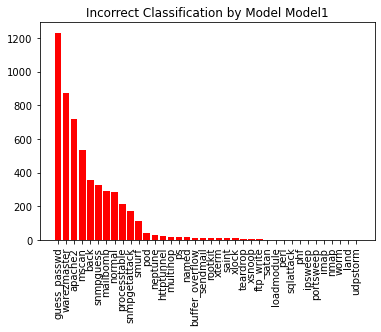

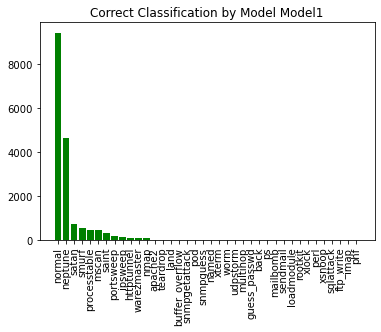

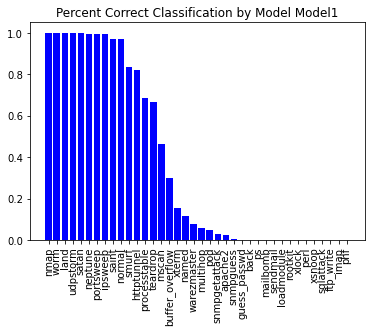

In [286]:
draw_plots(model1incorrect, model1correct, model1percent, 'Model1', prefix='01', save=True) 

In [224]:
print(accuracy_score(pred, ae_bin_test.values[:,-1]))
print(f1_score(pred, ae_bin_test.values[:,-1]))


0.7623208978396842
0.7433662228182777


In [226]:
attack_names = test_data['attack'].unique()
model1correct   = {i: 0 for i in attack_names}
model1incorrect = {i: 0 for i in attack_names}
model1percent   = {i: 0 for i in attack_names}
for i in range(len(pred)):
    tp = atk.decode_attack(pd.Series(TEST_MATRIX[i][-2]))
    tp = tp.values[0]
    if pred[i] == real[i]:
        model1correct[tp] += 1
    else:
        model1incorrect[tp] += 1
        
model1percent = {
    key: model1correct[key]/ (model1correct[key] + model1incorrect[key]) if key in model1incorrect else 1 for key in model1correct.keys() 
}
k = sorted(model1incorrect, key=lambda dict_key: abs(model1incorrect[dict_key]), reverse = True)

plt.bar(k, sorted(model1incorrect.values()), color='r')
plt.xticks(rotation=90)
plt.show
        

['nmap',
 'worm',
 'land',
 'udpstorm',
 'ipsweep',
 'portsweep',
 'imap',
 'satan',
 'loadmodule',
 'perl',
 'sqlattack',
 'phf',
 'ftp_write',
 'teardrop',
 'xsnoop',
 'saint',
 'xlock',
 'xterm',
 'rootkit',
 'buffer_overflow',
 'sendmail',
 'ps',
 'named',
 'multihop',
 'httptunnel',
 'neptune',
 'pod',
 'smurf',
 'snmpgetattack',
 'processtable',
 'normal',
 'mailbomb',
 'snmpguess',
 'back',
 'mscan',
 'apache2',
 'warezmaster',
 'guess_passwd']

<function matplotlib.pyplot.show(close=None, block=None)>

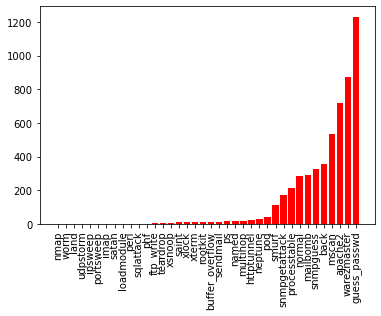

In [235]:
model1incorrect

{'neptune': 28,
 'normal': 286,
 'saint': 9,
 'mscan': 537,
 'guess_passwd': 1231,
 'smurf': 111,
 'apache2': 720,
 'satan': 2,
 'buffer_overflow': 14,
 'back': 359,
 'warezmaster': 871,
 'snmpgetattack': 173,
 'processtable': 216,
 'pod': 39,
 'httptunnel': 24,
 'nmap': 0,
 'ps': 15,
 'snmpguess': 329,
 'ipsweep': 1,
 'mailbomb': 293,
 'portsweep': 1,
 'multihop': 17,
 'named': 15,
 'sendmail': 14,
 'loadmodule': 2,
 'xterm': 11,
 'worm': 0,
 'teardrop': 4,
 'rootkit': 13,
 'xlock': 9,
 'perl': 2,
 'land': 0,
 'xsnoop': 4,
 'sqlattack': 2,
 'ftp_write': 3,
 'imap': 1,
 'udpstorm': 0,
 'phf': 2}

In [268]:
import xgboost as xgb

clf = xgb.XGBClassifier(use_label_encoder=False)

In [277]:
clf.fit(ae_bin_train.values[:,:-3], ae_bin_train.values[:,-1])

[22:07:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [279]:
from sklearn.metrics import accuracy_score
pred = clf.predict(ae_bin_test.values[:,:-3])
acc  = accuracy_score(ae_bin_test.values[:,-1], pred)
print(acc)

xgbincorrect, xgbcorrect, xgbpercent = get_stats(pred, ae_bin_test.values[:,-1])

0.7842789335935767


{'neptune': 4655, 'normal': 9440, 'saint': 317, 'mscan': 295, 'guess_passwd': 1, 'smurf': 665, 'apache2': 486, 'satan': 735, 'buffer_overflow': 5, 'back': 359, 'warezmaster': 168, 'snmpgetattack': 0, 'processtable': 103, 'pod': 39, 'httptunnel': 2, 'nmap': 73, 'ps': 2, 'snmpguess': 0, 'ipsweep': 141, 'mailbomb': 0, 'portsweep': 156, 'multihop': 3, 'named': 5, 'sendmail': 0, 'loadmodule': 1, 'xterm': 4, 'worm': 0, 'teardrop': 12, 'rootkit': 0, 'xlock': 0, 'perl': 2, 'land': 5, 'xsnoop': 1, 'sqlattack': 1, 'ftp_write': 1, 'imap': 0, 'udpstorm': 2, 'phf': 1}
{'neptune': 1, 'normal': 271, 'saint': 2, 'mscan': 701, 'guess_passwd': 1230, 'smurf': 0, 'apache2': 251, 'satan': 0, 'buffer_overflow': 15, 'back': 0, 'warezmaster': 776, 'snmpgetattack': 178, 'processtable': 582, 'pod': 2, 'httptunnel': 131, 'nmap': 0, 'ps': 13, 'snmpguess': 331, 'ipsweep': 0, 'mailbomb': 293, 'portsweep': 1, 'multihop': 15, 'named': 12, 'sendmail': 14, 'loadmodule': 1, 'xterm': 9, 'worm': 2, 'teardrop': 0, 'rootkit

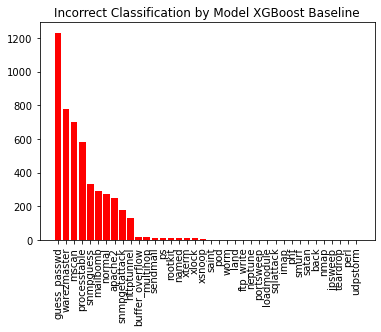

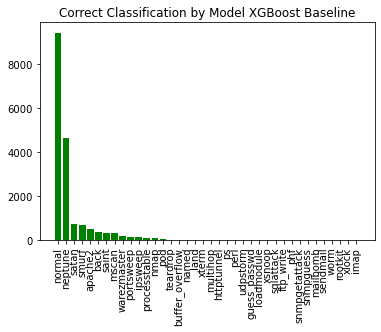

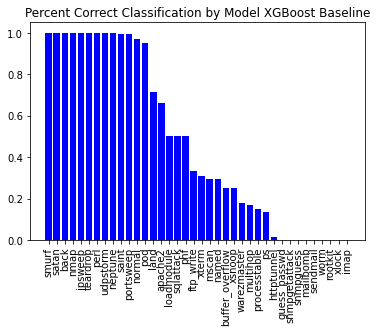

In [282]:
draw_plots(xgbincorrect, xgbcorrect, xgbpercent, 'XGBoost Baseline', prefix='00', save=True)

In [129]:
X_train = bin_train.iloc[:,:-2]
y_train = bin_train.iloc[:,-1]
X_test =  bin_test.iloc[:,:-2]
y_test =  bin_test.iloc[:,-1]

In [130]:
clf.fit(X_train, y_train)

[11:01:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [131]:
pred = clf.predict(X_test)
acc  = accuracy_score(y_test, pred)
print(acc)

0.789956971121856


In [14]:
import functools
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector
from pettingzoo.utils import wrappers

TRAIN_DATA         = ae_bin_train
TRAIN_MATRIX       = ae_bin_train.values
TRAIN_SUBMATRIX    = ae_bin_train.values
BATCH_SIZE         = 1
N_DISCRETE_ACTIONS = fin_train_data['broad_target'].nunique()
N_DISCRETE_ACTIONS_BIN = 2

class AdversarialCustomEnv(AECEnv):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, eps, N):
        super(AdversarialCustomEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        self.possible_agents = ['agent_env', 'agent_clf']
        self.env_actions = TRAIN_DATA['Attack Number'].unique()

        self._action_spaces = {'agent_env': spaces.Discrete(max(self.env_actions)), 'agent_clf': spaces.Discrete(N_DISCRETE_ACTIONS_BIN) }
        # Example for using image as input:
        self._observation_spaces = {agent: spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float)) for agent in self.possible_agents }
         
        self.envs = []
        
        self.eps  = eps
        self.ep   = 0

        self.N    = N
        self.turn = 0

        #Keep track of the distribution of states selected
        self.dist = {}
        #End an episode when all samples have been selected at least once
        self.seen = [False for i in range(len(TRAIN_MATRIX))]
        
        print(self._action_spaces)
        print(self._observation_spaces)


    #@functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
    # Gym spaces are defined and documented here: https://gym.openai.com/docs/#spaces
        print('obs called for ', agent)
        return self._observation_spaces[agent]

    #@functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self._action_spaces[agent]


    def step(self, action):
        environment_action = action[0]
        classifier_action = action[1]

        classifier_reward = 1 if self.last_label == classifier_action else -1
        environment_reward = -1*classifier_reward

        print('rewards after step: ', classifier_reward, ' ', environment_reward)


        empty = True
        while empty:
            if environment_action in self.env_actions:
                TRAIN_SUBMATRIX = TRAIN_DATA.loc[TRAIN_DATA['Attack Number'] == environment_action]
                indxs = [random.choice(ae_bin_train.loc[ae_bin_train['Attack Number'] == environment_action].index) for i in range(BATCH_SIZE)]
                test_pull = TRAIN_MATRIX[indxs]
                empty = False

                for indx in range(len(indxs)):
                    self.seen[indx] = True
                    if indx in self.dist:
                        self.dist[indx] += 1
                    else:
                        self.dist[indx] = 1

                raw_observation = test_pull[0]
                self.last_label = int(raw_observation[-1])
                observation     = raw_observation[:-3]

            else:
                # If the environment selects an invalid action, take a random action and subtract 1 from its reward
                print(environment_action, ': Not in ')
                print(list(self.env_actions))
                environment_reward -= 1
                classifier_reward  += 1

                print('rewards after invalid action: ', classifier_reward, ' ', environment_reward)

                indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]
                #print(TRAIN_MATRIX[indxs])
                environment_action = TRAIN_MATRIX[indxs][0][-2]

        # Fix this to run through the dataset each episode
        done = not False in self.seen
        info            = {}

        reward = (environment_reward, classifier_reward)
        return observation, reward, done, info

    def reset(self):
        
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.state = {agent: None for agent in self.agents}
        self.observations = {agent: None for agent in self.agents}
        self.num_moves = 0
        '''
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        '''
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()
        
        
        
        indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]

        raw_observation = TRAIN_MATRIX[indxs][0]
        self.last_label = int(raw_observation[-1])
        observation     = raw_observation[:-3]
        # print(indxs)
        # print(self.last_label)
        # print(raw_observation)
        self.turn += 1
        self.turn = self.turn % self.N
        return observation  # reward, done, info can't be included

    def render(self, mode='human'):
        pass
    def close (self):
        pass

In [396]:
import functools
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector
from pettingzoo.utils import wrappers

TRAIN_DATA         = ae_bin_train
TRAIN_MATRIX       = ae_bin_train.values
TRAIN_SUBMATRIX    = ae_bin_train.values
BATCH_SIZE         = 1
N_DISCRETE_ACTIONS = fin_train_data['broad_target'].nunique()
N_DISCRETE_ACTIONS_BIN = 2

class AdversarialCustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, eps, N, player):
        super(AdversarialCustomEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        
        #self.possible_agents = ['agent_env', 'agent_clf']
        self.env_actions = TRAIN_DATA['Attack Number'].unique()

        self.action_space = spaces.Tuple((spaces.Discrete(max(self.env_actions)), spaces.Discrete(N_DISCRETE_ACTIONS_BIN)))# {'agent_env': spaces.Discrete(max(self.env_actions)), 'agent_clf': spaces.Discrete(N_DISCRETE_ACTIONS_BIN) }
        # Example for using image as input:
        self.observation_spaces = spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float))# for agent in self.possible_agents }
         
        self.envs = []
        
        self.eps  = eps
        self.ep   = 0

        self.N    = N
        self.turn = 0

        #Keep track of the distribution of states selected
        self.dist = {}
        #End an episode when all samples have been selected at least once
        self.seen = [False for i in range(len(TRAIN_MATRIX))]
        self.player = player
        



#     #@functools.lru_cache(maxsize=None)
#     def observation_space(self, agent):
#     # Gym spaces are defined and documented here: https://gym.openai.com/docs/#spaces
#         print('obs called for ', agent)
#         return self._observation_spaces[agent]

#     #@functools.lru_cache(maxsize=None)
#     def action_space(self, agent):
#         return self._action_spaces[agent]


    def step(self, action):
        environment_action = action[0]
        classifier_action  = action[1]

        classifier_reward = 1 if self.last_label == classifier_action else -1
        environment_reward = -1*classifier_reward

        print('rewards after step: ', classifier_reward, ' ', environment_reward)


        empty = True
        while empty:
            if environment_action in self.env_actions:
                TRAIN_SUBMATRIX = TRAIN_DATA.loc[TRAIN_DATA['Attack Number'] == environment_action]
                indxs = [random.choice(ae_bin_train.loc[ae_bin_train['Attack Number'] == environment_action].index) for i in range(BATCH_SIZE)]
                test_pull = TRAIN_MATRIX[indxs]
                empty = False

                for indx in range(len(indxs)):
                    self.seen[indx] = True
                    if indx in self.dist:
                        self.dist[indx] += 1
                    else:
                        self.dist[indx] = 1

                raw_observation = test_pull[0]
                self.last_label = int(raw_observation[-1])
                observation     = raw_observation[:-3]

            else:
                # If the environment selects an invalid action, take a random action and subtract 1 from its reward
                print(environment_action, ': Not in ')
                print(list(self.env_actions))
                environment_reward -= 1
                classifier_reward  += 1

                print('rewards after invalid action: ', classifier_reward, ' ', environment_reward)

                indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]
                #print(TRAIN_MATRIX[indxs])
                environment_action = TRAIN_MATRIX[indxs][0][-2]

        # Fix this to run through the dataset each episode
        done = not False in self.seen
        info            = {}

        reward = (environment_reward, classifier_reward)
        return observation, reward, done, info

    def reset(self):
        
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.state = {agent: None for agent in self.agents}
        self.observations = {agent: None for agent in self.agents}
        self.num_moves = 0
        '''
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        '''
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()
        
        
        
        indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]

        raw_observation = TRAIN_MATRIX[indxs][0]
        self.last_label = int(raw_observation[-1])
        observation     = raw_observation[:-3]
        # print(indxs)
        # print(self.last_label)
        # print(raw_observation)
        self.turn += 1
        self.turn = self.turn % self.N
        return observation  # reward, done, info can't be included

    def render(self, mode='human'):
        pass
    def close (self):
        pass

In [140]:
#import ray
from ray.rllib.env import MultiAgentEnv
import functools
from gym import spaces
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector
from pettingzoo.utils import wrappers


TRAIN_DATA         = ae_bin_train
TRAIN_MATRIX       = ae_bin_train.values
TRAIN_SUBMATRIX    = ae_bin_train.values
BATCH_SIZE         = 1
N_DISCRETE_ACTIONS = fin_train_data['broad_target'].nunique()
N_DISCRETE_ACTIONS_BIN = 2

class AdversarialCustomEnv(MultiAgentEnv):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    env_actions = TRAIN_DATA['Attack Number'].unique()
    
    action_mapping = {
        'env': spaces.Discrete(max(env_actions)),
        'clf': spaces.Discrete(2)
    }
    obs_mapping = {
        'env': spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float)),
        'clf': spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float))
    }

    @staticmethod
    def get_obs_space(type):
        return spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float))
    
    @staticmethod
    def get_action_space(type):
        return CustomEnv.action_mapping[type]
    
    
    def __init__(self, eps=1, N=2, player=0):
        super(AdversarialCustomEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        
        self.possible_agents = ['env', 'clf']
        self.env_actions = TRAIN_DATA['Attack Number'].unique()

        self._action_spaces = {'env': spaces.Discrete(max(self.env_actions)), 'clf': spaces.Discrete(N_DISCRETE_ACTIONS_BIN) }# {'agent_env': spaces.Discrete(max(self.env_actions)), 'agent_clf': spaces.Discrete(N_DISCRETE_ACTIONS_BIN) }
        # Example for using image as input:
        self._observation_spaces = spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float))# for agent in self.possible_agents }
         
        self.envs = []
        
        self.eps  = eps
        self.ep   = 0

        self.N    = N
        self.turn = 0

        #Keep track of the distribution of states selected
        self.dist = {}
        #Just for attack types
        self.att_dist = {i: 0 for i in self.env_actions}
        #End an episode when all samples have been selected at least once
        self.seen = [False for i in range(len(TRAIN_MATRIX))]
        self.player = player
        self.debug  = 0
        



    #@functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
    # Gym spaces are defined and documented here: https://gym.openai.com/docs/#spaces
        print('obs called for ', agent)
        return self._observation_spaces[agent]

    #@functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self._action_spaces[agent]


    def step(self, action):
        #print(action)
        environment_action = action['env']
        classifier_action  = action['clf']

        classifier_reward = 1 if self.last_label == classifier_action else -1
        environment_reward = -1*classifier_reward

        #print('rewards after step: ', classifier_reward, ' ', environment_reward)


        empty = True
        while empty:
            if environment_action in self.env_actions:
                TRAIN_SUBMATRIX = TRAIN_DATA.loc[TRAIN_DATA['Attack Number'] == environment_action]
                indxs = [random.choice(ae_bin_train.loc[ae_bin_train['Attack Number'] == environment_action].index) for i in range(BATCH_SIZE)]
                test_pull = TRAIN_MATRIX[indxs]
                empty = False
                if self.debug > 5:
                    print('------------------DEBUG INFO---------------------')
                    print('*** environment_action: ', environment_action)
                    print('*** len TRAIN_SUBMATRIX: ', len(ae_bin_train.loc[ae_bin_train['Attack Number'] == environment_action]))
                    print('*** indxs ', indxs)
                
                for indx in indxs:
                    
                    self.seen[indx] = True
                    if indx in self.dist:
                        self.dist[indx] += 1
                    else:
                        self.dist[indx] = 1
                #print(indx)
                self.att_dist[environment_action] += 1
                raw_observation = test_pull[0]
                self.last_label = int(raw_observation[-1])
                observation     = {agent: raw_observation[:-3].reshape(1,122) for agent in self.agents}

            else:
                # If the environment selects an invalid action, take a random action and subtract 1 from its reward
                # print(environment_action, ': Not in ')
                # print(list(self.env_actions))
                environment_reward -= 1
                classifier_reward  += 1

                #print('rewards after invalid action: ', classifier_reward, ' ', environment_reward)

                indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]
                #print(TRAIN_MATRIX[indxs])
                environment_action = TRAIN_MATRIX[indxs][0][-2]

        # Fix this to run through the dataset each episode
        done = {agent: not False in self.seen for agent in self.agents + ['__all__'] }
        info            = {agent: {} for agent in self.agents}

        reward = {'env': environment_reward, 'clf': classifier_reward}
        self.turn += 1
        if self.turn % 1000 == 0:
            print(len(self.dist))
            print(len(TRAIN_MATRIX) - len(self.dist), ' remaining~!')
            print('______________Attack Distributions Chosen___________________')
            print(self.att_dist)
        if done['__all__']:
            print('DONE')
            print(self.seen)
        return observation, reward, done, info

    def reset(self):
        
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.state = {agent: None for agent in self.agents}
        self.observations = {agent: None for agent in self.agents}
        self.num_moves = 0
        '''
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        '''
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()
        
        
        
        indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]

        raw_observation = TRAIN_MATRIX[indxs][0]
        self.last_label = int(raw_observation[-1])
        observation     = {agent: raw_observation[:-3].reshape(1,122) for agent in self.agents}
        # print(indxs)
        # print(self.last_label)
        # print(raw_observation)
        self.turn += 1

        return observation  # reward, done, info can't be included

    def render(self, mode='human'):
        pass
    def close (self):
        pass


In [143]:
import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.registry import register_env

conf = dqn.DEFAULT_CONFIG.copy()
conf2['framework'] = 'torch'
conf2['timesteps_per_iteration'] = 5000
a = DQNTrainer(conf2, env = AdversarialCustomEnv)
for i in range(2):
    a.train()

Install gputil for GPU system monitoring.


801
125171  remaining~!
______________Attack Distributions Chosen___________________
{32: 237, 34: 151, 21: 20, 38: 53, 13: 45, 10: 38, 14: 23, 28: 39, 16: 28, 0: 37, 12: 19, 3: 19, 33: 29, 19: 29, 2: 26, 29: 33, 15: 31, 1: 31, 39: 0, 8: 31, 9: 24, 24: 30, 4: 26}
1514
124458  remaining~!
______________Attack Distributions Chosen___________________
{32: 464, 34: 300, 21: 52, 38: 91, 13: 74, 10: 72, 14: 56, 28: 79, 16: 70, 0: 66, 12: 65, 3: 48, 33: 59, 19: 49, 2: 41, 29: 70, 15: 54, 1: 64, 39: 0, 8: 57, 9: 58, 24: 54, 4: 56}
2233
123739  remaining~!
______________Attack Distributions Chosen___________________
{32: 706, 34: 453, 21: 80, 38: 129, 13: 147, 10: 95, 14: 99, 28: 119, 16: 106, 0: 108, 12: 94, 3: 78, 33: 87, 19: 71, 2: 59, 29: 92, 15: 86, 1: 80, 39: 0, 8: 82, 9: 79, 24: 73, 4: 76}
2886
123086  remaining~!
______________Attack Distributions Chosen___________________
{32: 882, 34: 587, 21: 95, 38: 167, 13: 228, 10: 130, 14: 137, 28: 154, 16: 154, 0: 171, 12: 135, 3: 94, 33: 106, 1

In [64]:
conf2 = {
    'multiagent': {
            'policies': {
                    'environment': (None, AdversarialCustomEnv.obs_mapping['env'], AdversarialCustomEnv.action_mapping['env'], {'agent_id': 'env', 'Gamma': 0.8}),
                    'classifier':  (None, AdversarialCustomEnv.obs_mapping['clf'], AdversarialCustomEnv.action_mapping['clf'], {'agent_id': 'clf', 'Gamma': 0.01})
            },
            'policy_mapping_fn': lambda agent_id: 'environment' if agent_id == 'env' else 'classifier',
            'policies_to_train': ['environment', 'classifier'],
    },
}

In [293]:
#obs = env.reset()
rews = 0
tots = 0
correct_dist = {}
incorrect_dist = {}
percent_dist = {}
pred = [-1 for i in range(len(TEST_MATRIX))]
TEST_MATRIX = ae_bin_test.values
i = 0
for row in TEST_MATRIX:
    action = a.compute_single_action(row[:-3],
                             policy_id = 'classifier')
    pred[i] = action
    i += 1
    if action == int(row[-1]):
        rews += 1
        if row[-2] in correct_dist:
            correct_dist[row[-2]] += 1
        else:
            correct_dist[row[-2]] = 1
    else:
        if row[-2] in incorrect_dist:
            incorrect_dist[row[-2]] += 1
        else:
            incorrect_dist[row[-2]] = 1
    tots += 1
print('Correct: ', rews)
print('Total: ', tots)
print('Accuracy ', rews/tots)
print('F1: ', f1_score(pred, TEST_MATRIX[:,-1]))

    # obs, reward, done, info = env.step(action)
    # env.render()
    # if done:
    #   obs = env.reset()

Correct:  17746
Total:  22543
Accuracy  0.7872066716940957
F1:  0.806689502317147


{'neptune': 4614, 'normal': 7727, 'saint': 312, 'mscan': 403, 'guess_passwd': 54, 'smurf': 662, 'apache2': 622, 'satan': 730, 'buffer_overflow': 18, 'back': 354, 'warezmaster': 918, 'snmpgetattack': 23, 'processtable': 496, 'pod': 39, 'httptunnel': 123, 'nmap': 73, 'ps': 10, 'snmpguess': 4, 'ipsweep': 141, 'mailbomb': 169, 'portsweep': 155, 'multihop': 14, 'named': 14, 'sendmail': 9, 'loadmodule': 1, 'xterm': 13, 'worm': 2, 'teardrop': 12, 'rootkit': 10, 'xlock': 8, 'perl': 2, 'land': 7, 'xsnoop': 4, 'sqlattack': 2, 'ftp_write': 2, 'imap': 0, 'udpstorm': 2, 'phf': 1}
{'neptune': 42, 'normal': 1984, 'saint': 7, 'mscan': 593, 'guess_passwd': 1177, 'smurf': 3, 'apache2': 115, 'satan': 5, 'buffer_overflow': 2, 'back': 5, 'warezmaster': 26, 'snmpgetattack': 155, 'processtable': 189, 'pod': 2, 'httptunnel': 10, 'nmap': 0, 'ps': 5, 'snmpguess': 327, 'ipsweep': 0, 'mailbomb': 124, 'portsweep': 2, 'multihop': 4, 'named': 3, 'sendmail': 5, 'loadmodule': 1, 'xterm': 0, 'worm': 0, 'teardrop': 0, '

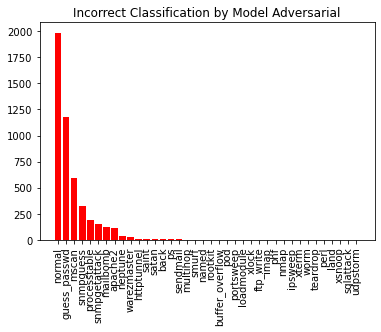

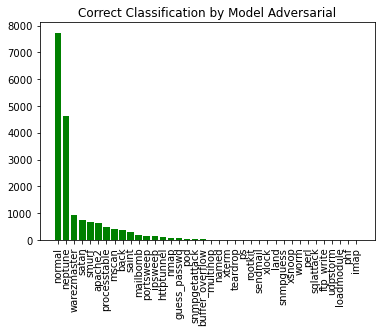

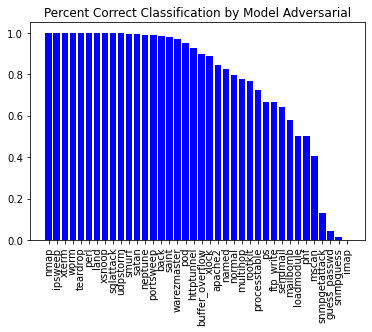

In [292]:
percent_dist = {
    key: correct_dist[key]/ (correct_dist[key] + incorrect_dist[key]) if key in incorrect_dist else 1 for key in correct_dist.keys() 
}
incorrect_dist2, correct_dist2, percent_dist2 = get_stats(pred, TEST_MATRIX[:,-1])
draw_plots(incorrect_dist2, correct_dist2, percent_dist2, 'Adversarial', prefix='02', save=True)

<function matplotlib.pyplot.show(close=None, block=None)>

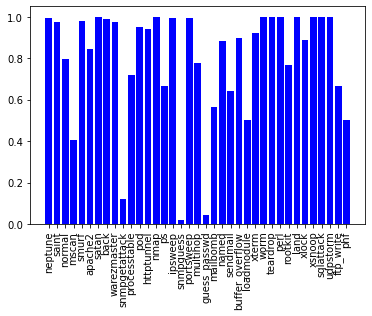

In [178]:
plt.bar(atk.decode_attack(pd.Series(list(percent_dist.keys()))), percent_dist.values(), color='b')
plt.xticks(rotation=90)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

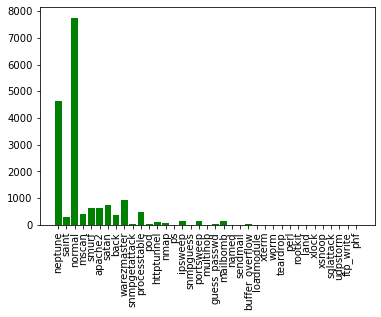

In [179]:
import matplotlib.pyplot as plt

plt.bar(atk.decode_attack(pd.Series(list(correct_dist.keys()))), correct_dist.values(), color='g')
plt.xticks(rotation=90)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

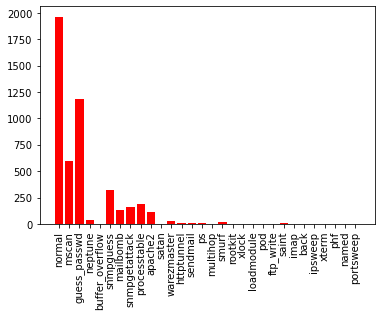

In [180]:
plt.bar(atk.decode_attack(pd.Series(list(incorrect_dist.keys()))), incorrect_dist.values(), color='r')
plt.xticks(rotation=90)
plt.show

In [120]:
#train_data = pd.read_csv('NSL-KDD/KDDTrain+.txt')
train_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,_count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125968,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125969,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125970,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


<function matplotlib.pyplot.show(close=None, block=None)>

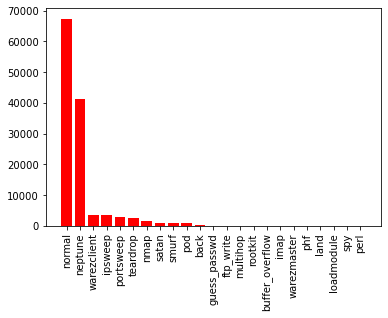

In [122]:
plt.bar(train_data['attack'].unique(), train_data['attack'].value_counts(), color='r')
plt.xticks(rotation=90)
plt.show

In [154]:
b = atk.encode_attack(train_data['attack'])
b

0         32
1         34
2         32
3         32
4         34
          ..
125967    34
125968    32
125969    32
125970    34
125971    32
Name: attack, Length: 125972, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

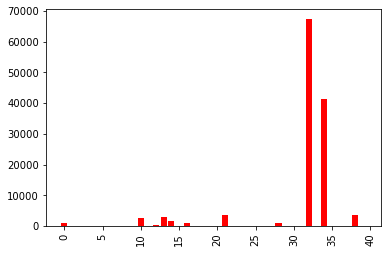

In [155]:
plt.bar(b.unique(), b.value_counts(), color='r')
plt.xticks(rotation=90)
plt.show

In [156]:
c = atk.decode_attack(b)

<function matplotlib.pyplot.show(close=None, block=None)>

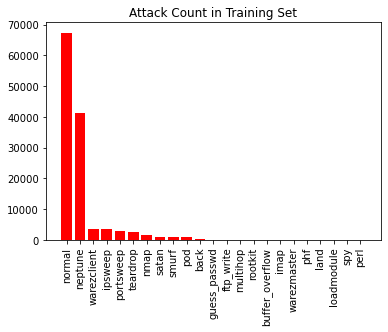

In [175]:
plt.bar(c.unique(), c.value_counts(), color='r')
plt.title('Attack Count in Training Set')
plt.xticks(rotation=90)
plt.savefig('AttackCount.pdf', bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

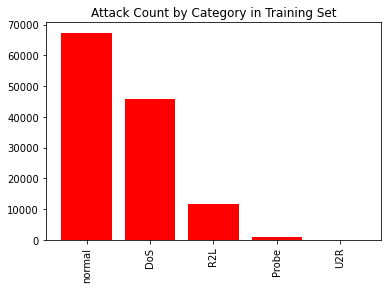

In [170]:
d = c.map(attack_category_map)
plt.bar(d.unique(), d.value_counts(), color='r')
plt.title('Attack Count by Category in Training Set')
plt.xticks(rotation=90)
plt.show

In [183]:
import xgboost as xgb

clf = xgb.XGBClassifier(use_label_encoder=False)
clf.fit(TRAIN_MATRIX[:,:-3], TRAIN_MATRIX[:,-1])

[19:17:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [200]:
from sklearn.metrics import accuracy_score, f1_score
pred = clf.predict(TEST_MATRIX[:,:-3])
print(accuracy_score(pred, TEST_MATRIX[:,-1]))
print(f1_score(pred, TEST_MATRIX[:,-1]))

0.7842789335935767
0.772150119477112


In [251]:
def get_stats(pred, true):
    attack_names = test_data['attack'].unique()
    correct   = {i: 0 for i in attack_names}
    incorrect = {i: 0 for i in attack_names}
    percent   = {i: 0 for i in attack_names}

    for i in range(len(pred)):
        tp = atk.decode_attack(pd.Series(TEST_MATRIX[i][-2]))
        tp = tp.values[0]
        if pred[i] == true[i]:
            correct[tp] += 1
        else:
            incorrect[tp] += 1
            
    percent = {
        key: correct[key]/ (correct[key] + incorrect[key]) if key in incorrect else 1 for key in correct.keys() 
    }   
    
    return correct, incorrect, percent
        

In [267]:
def draw_plots(correct, incorrect, percent, Classifier_Name, prefix='00', save=False):
    
    print(correct)
    print(incorrect)
    
    correct_keys   = sorted(correct, key=lambda dict_key: abs(correct[dict_key]), reverse = True)
    incorrect_keys = sorted(incorrect, key=lambda dict_key: abs(incorrect[dict_key]), reverse = True)
    percent_keys   = sorted(percent, key=lambda dict_key: abs(percent[dict_key]), reverse = True)
    
    

    attack_names = test_data['attack'].unique()
    plt.bar(incorrect_keys, sorted(incorrect.values(), reverse=True), color='r')
    plt.xticks(rotation=90)
    plt.title('Incorrect Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Incorrect' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()
    
    plt.bar(correct_keys, sorted(correct.values(), reverse=True), color='g')
    plt.xticks(rotation=90)
    plt.title('Correct Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Correct' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()
    
    plt.bar(percent_keys, sorted(percent.values(), reverse=True), color='b')
    plt.xticks(rotation=90)
    plt.title('Percent Correct Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Percent' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()


{'neptune': 4628, 'normal': 9425, 'saint': 310, 'mscan': 459, 'guess_passwd': 0, 'smurf': 554, 'apache2': 17, 'satan': 733, 'buffer_overflow': 6, 'back': 0, 'warezmaster': 73, 'snmpgetattack': 5, 'processtable': 469, 'pod': 2, 'httptunnel': 109, 'nmap': 73, 'ps': 0, 'snmpguess': 2, 'ipsweep': 140, 'mailbomb': 0, 'portsweep': 156, 'multihop': 1, 'named': 2, 'sendmail': 0, 'loadmodule': 0, 'xterm': 2, 'worm': 2, 'teardrop': 8, 'rootkit': 0, 'xlock': 0, 'perl': 0, 'land': 7, 'xsnoop': 0, 'sqlattack': 0, 'ftp_write': 0, 'imap': 0, 'udpstorm': 2, 'phf': 0}
{'neptune': 28, 'normal': 286, 'saint': 9, 'mscan': 537, 'guess_passwd': 1231, 'smurf': 111, 'apache2': 720, 'satan': 2, 'buffer_overflow': 14, 'back': 359, 'warezmaster': 871, 'snmpgetattack': 173, 'processtable': 216, 'pod': 39, 'httptunnel': 24, 'nmap': 0, 'ps': 15, 'snmpguess': 329, 'ipsweep': 1, 'mailbomb': 293, 'portsweep': 1, 'multihop': 17, 'named': 15, 'sendmail': 14, 'loadmodule': 2, 'xterm': 11, 'worm': 0, 'teardrop': 4, 'rootk

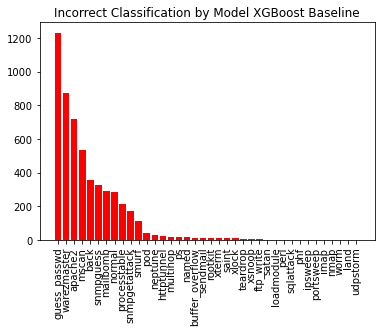

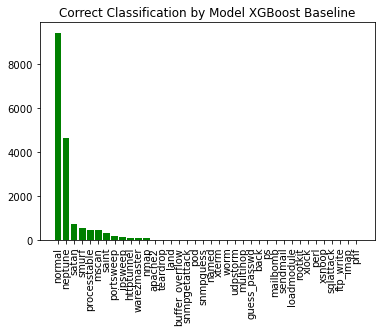

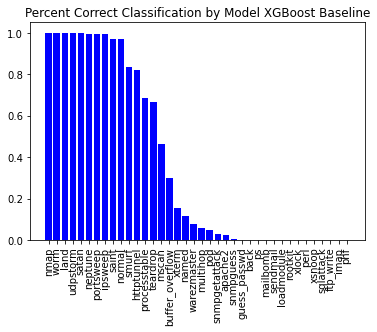

In [265]:
draw_plots(*get_stats(pred, TEST_MATRIX[:,-1]), 'XGBoost Baseline', save=True)

In [250]:
c, incorrect, _ = get_stats(pred, TRAIN_MATRIX[:,-1])
display(_)
atk.decode_attack(pd.Series(list(incorrect.keys())))

{'neptune': 0,
 'normal': 0,
 'saint': 0,
 'mscan': 0,
 'guess_passwd': 0,
 'smurf': 0,
 'apache2': 0,
 'satan': 0,
 'buffer_overflow': 0,
 'back': 0,
 'warezmaster': 0,
 'snmpgetattack': 0,
 'processtable': 0,
 'pod': 0,
 'httptunnel': 0,
 'nmap': 0,
 'ps': 0,
 'snmpguess': 0,
 'ipsweep': 0,
 'mailbomb': 0,
 'portsweep': 0,
 'multihop': 0,
 'named': 0,
 'sendmail': 0,
 'loadmodule': 0,
 'xterm': 0,
 'worm': 0,
 'teardrop': 0,
 'rootkit': 0,
 'xlock': 0,
 'perl': 0,
 'land': 0,
 'xsnoop': 0,
 'sqlattack': 0,
 'ftp_write': 0,
 'imap': 0,
 'udpstorm': 0,
 'phf': 0}

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
30    NaN
31    NaN
32    NaN
33    NaN
34    NaN
35    NaN
36    NaN
37    NaN
dtype: object